In [12]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [13]:
df = pd.read_csv('/Users/sachacollinson/Downloads/simulated_transaction_2024.csv')

In [14]:
df

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name
0,01/01/2023,00:00,678330503.0,2971.000000,1584.00,NaN,Westport Care Home
1,01/01/2023,00:00,472213568.0,3792.000000,1950.00,NaN,Barbiee Boutique
2,01/01/2023,00:00,472213568.0,3012.000000,-780.00,283027736.0,NaN
3,01/01/2023,00:00,283027736.0,1787.000000,780.00,472213568.0,NaN
4,01/01/2023,00:00,624500124.0,3226.000000,1825.00,NaN,Fat Face
...,...,...,...,...,...,...,...
230591,06/12/2023,20:54,581655972.0,45935.206861,-41.06,NaN,Tesco
230592,06/12/2023,20:55,786141370.0,-244.837500,-62.35,NaN,Sainsbury Local
230593,06/12/2023,21:05,824916823.0,9709.172159,-32.94,NaN,Deliveroo
230594,06/12/2023,21:13,366550080.0,26834.165794,-19.25,NaN,Amazon


In [15]:
# Ensure TransactionDate is in datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)  # Adjusting for day-first format
end_date = pd.Timestamp('2025-12-31')

# RFM Calculation
rfm = df.groupby('Account No').agg({
    'Account No': 'count',
    'Amount': 'sum'
}).rename(columns={'Account No': 'Frequency',
                   'Amount': 'MonetaryValue'})

# Scoring RFM values
# Quantiles can be adjusted as needed
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Apply the scoring
rfm['F_Score'] = rfm['Frequency'].apply(lambda x: 4 if x <= quantiles['Frequency'][0.25] else 3 if x <= quantiles['Frequency'][0.50] else 2 if x <= quantiles['Frequency'][0.75] else 1)
rfm['M_Score'] = rfm['MonetaryValue'].apply(rfm_score, args=('MonetaryValue', quantiles,))

# Combine RFM scores
rfm['RFM_Score'] =  rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Display the final RFM segmentation
print(rfm.head())

             Frequency  MonetaryValue  F_Score  M_Score RFM_Score
Account No                                                       
101531259.0        123        -716.08        4        2        42
104832000.0        164       -4565.52        3        1        31
105375973.0        158        -193.77        3        3        33
106601471.0        193       10649.00        3        4        34
108481285.0        368       10038.92        1        4        14


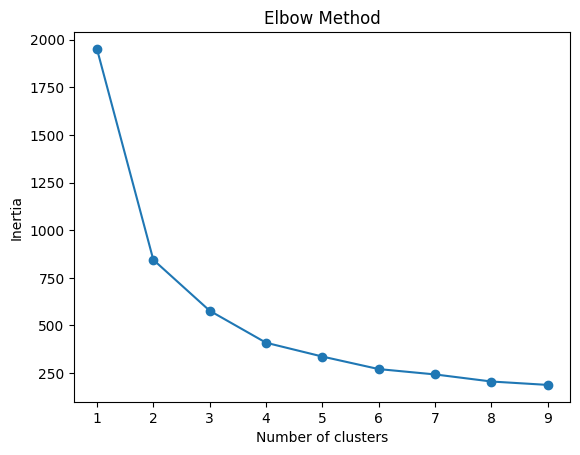

In [16]:
# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[[ 'Frequency', 'MonetaryValue']])

# Determine the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [17]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Examine cluster centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=[ 'Frequency', 'MonetaryValue'])
print(centroids)

# Analyze cluster characteristics
for cluster in sorted(rfm['Cluster'].unique()):
    print(f"\nCluster {cluster} Characteristics:")
    cluster_data = rfm[rfm['Cluster'] == cluster]
    print(cluster_data.describe())

    Frequency  MonetaryValue
0  353.240964    3779.981566
1  438.250000   18723.358333
2  164.233281   -1600.879907

Cluster 0 Characteristics:
        Frequency  MonetaryValue     F_Score     M_Score  Cluster
count  249.000000     249.000000  249.000000  249.000000    249.0
mean   353.240964    3779.981566    1.333333    3.449799      0.0
std     95.708511    3658.097143    0.497305    0.700295      0.0
min    192.000000   -2303.140000    1.000000    1.000000      0.0
25%    280.000000     680.060000    1.000000    3.000000      0.0
50%    331.000000    3212.530000    1.000000    4.000000      0.0
75%    418.000000    6670.430000    2.000000    4.000000      0.0
max    695.000000   14312.370000    3.000000    4.000000      0.0

Cluster 1 Characteristics:
        Frequency  MonetaryValue    F_Score  M_Score  Cluster
count   84.000000      84.000000  84.000000     84.0     84.0
mean   438.250000   18723.358333   1.142857      4.0      1.0
std    119.137955    7992.181970   0.384735     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


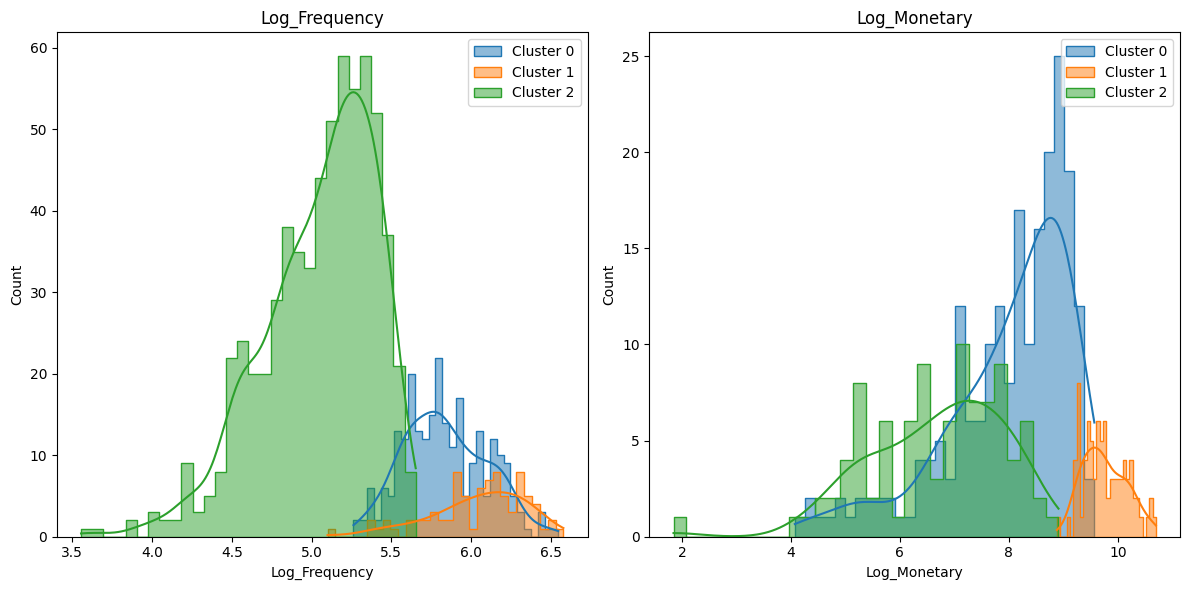

In [18]:
# Apply log transformation to 'Frequency' and 'Monetary' to handle wide ranges
rfm['Log_Frequency'] = np.log1p(rfm['Frequency'])
rfm['Log_Monetary'] = np.log1p(rfm['MonetaryValue'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Increased figure size
axes = axes.flatten()

features = [ 'Log_Frequency', 'Log_Monetary']
for i, feature in enumerate(features):
    for cluster in range(kmeans.n_clusters):
        # Adjust bin size for better visualization
        sns.histplot(rfm[rfm['Cluster'] == cluster][feature], ax=axes[i], label=f'Cluster {cluster}', kde=True, bins=30, element='step')
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

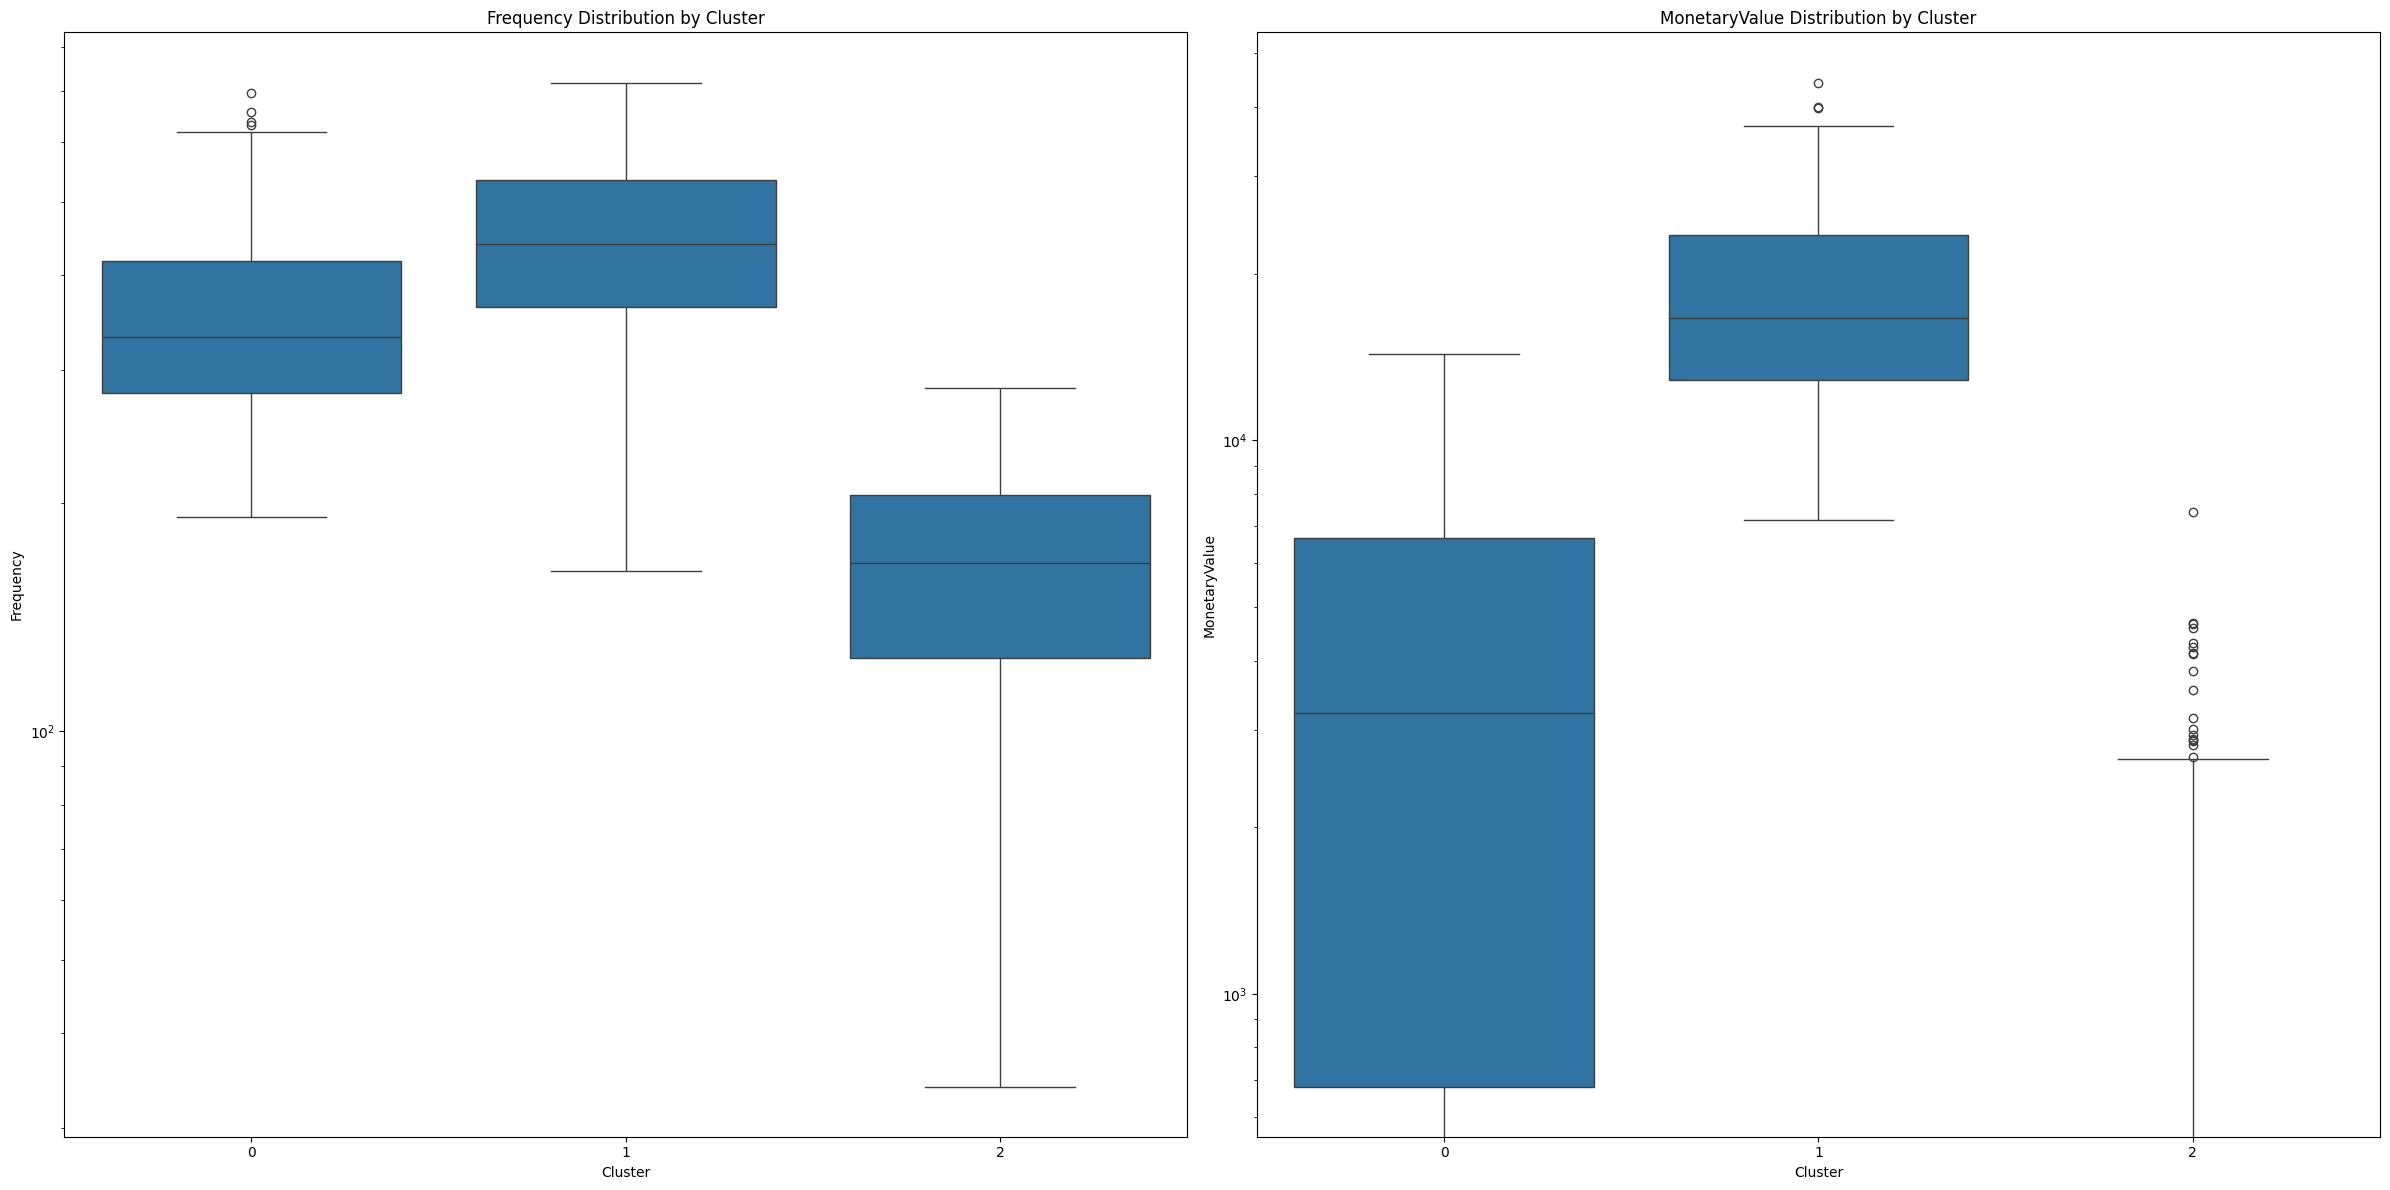

In [19]:
features = ['Frequency', 'MonetaryValue']
fig, axes = plt.subplots(1, 2, figsize=(24, 12))  # Adjust the size as needed

for i, feature in enumerate(features):
    sns.boxplot(x='Cluster', y=feature, data=rfm, ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Cluster')
    # Optional: To improve readability, you might log-transform Frequency and Monetary values
    if feature in ['Frequency', 'MonetaryValue']:
        axes[i].set_yscale('log')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [29]:
# RFM Calculation
df.dropna(subset=['Balance', 'Amount','Account No'], inplace=True)
fmb = df.groupby('Account No').agg({
    'Account No': 'count',
    'Amount': 'sum',
    'Balance': 'mean'
}).rename(columns={'Account No': 'Frequency',
                   'Amount': 'MonetaryValue'})

# Scoring RFM values
# Quantiles can be adjusted as needed
quantiles = fmb.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Apply the scoring
fmb['F_Score'] = fmb['Frequency'].apply(lambda x: 4 if x <= quantiles['Frequency'][0.25] else 3 if x <= quantiles['Frequency'][0.50] else 2 if x <= quantiles['Frequency'][0.75] else 1)
fmb['M_Score'] = fmb['MonetaryValue'].apply(rfm_score, args=('MonetaryValue', quantiles,))

# Combine RFM scores
fmb['RFM_Score'] =  fmb['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Display the final RFM segmentation
print(fmb.head())

             Frequency  MonetaryValue      Balance  F_Score  M_Score RFM_Score
Account No                                                                    
101531259.0        122        -716.08   256.662295        4        2        42
104832000.0        164       -4565.52 -1188.593268        3        1        31
105375973.0        158        -193.77   110.995337        3        3        33
106601471.0        192       10649.00  6837.358765        3        4        34
108481285.0        368       10038.92  6830.116572        1        4        14


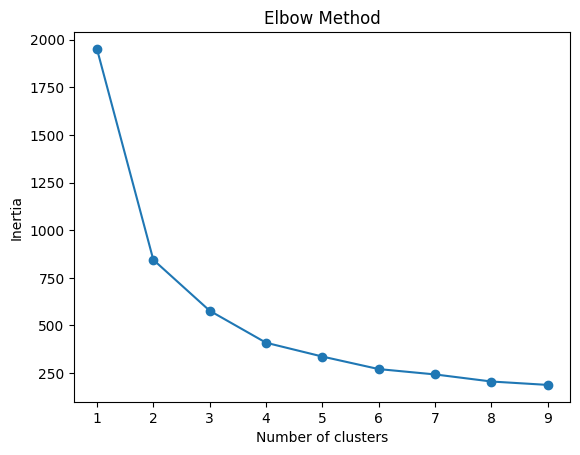

In [30]:
# Standardize the data
scaler = StandardScaler()
fmb_scaled = scaler.fit_transform(fmb[[ 'Frequency', 'MonetaryValue','Balance']])

# Determine the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [36]:
kmeans = KMeans(n_clusters=3, random_state=42)
fmb['Cluster'] = kmeans.fit_predict(fmb_scaled)

# Examine cluster centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=[ 'Frequency', 'MonetaryValue','Balance'])
print(centroids)

# Analyze cluster characteristics
for cluster in sorted(fmb['Cluster'].unique()):
    print(f"\nCluster {cluster} Characteristics:")
    cluster_data = fmb[fmb['Cluster'] == cluster]
    print(cluster_data.describe())

    Frequency  MonetaryValue       Balance
0  388.500000    5455.192798   4759.501361
1  405.949153   21891.276441  14421.809184
2  173.496423   -1402.298670    321.917709

Cluster 0 Characteristics:
        Frequency  MonetaryValue      Balance     F_Score     M_Score  \
count  218.000000     218.000000   218.000000  218.000000  218.000000   
mean   388.500000    5455.192798  4759.501361    1.201835    3.660550   
std    105.803846    4054.989087  2293.196599    0.424586    0.595222   
min    191.000000   -2303.140000   399.870108    1.000000    1.000000   
25%    316.500000    2196.745000  2751.483009    1.000000    3.000000   
50%    378.000000    5289.245000  4672.578797    1.000000    4.000000   
75%    466.750000    8497.175000  6544.087450    1.000000    4.000000   
max    695.000000   14328.360000  9693.601702    3.000000    4.000000   

       Cluster  Log_Frequency  Log_Monetary  Log_Balance  
count    218.0     218.000000    198.000000   218.000000  
mean       0.0       5.9

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


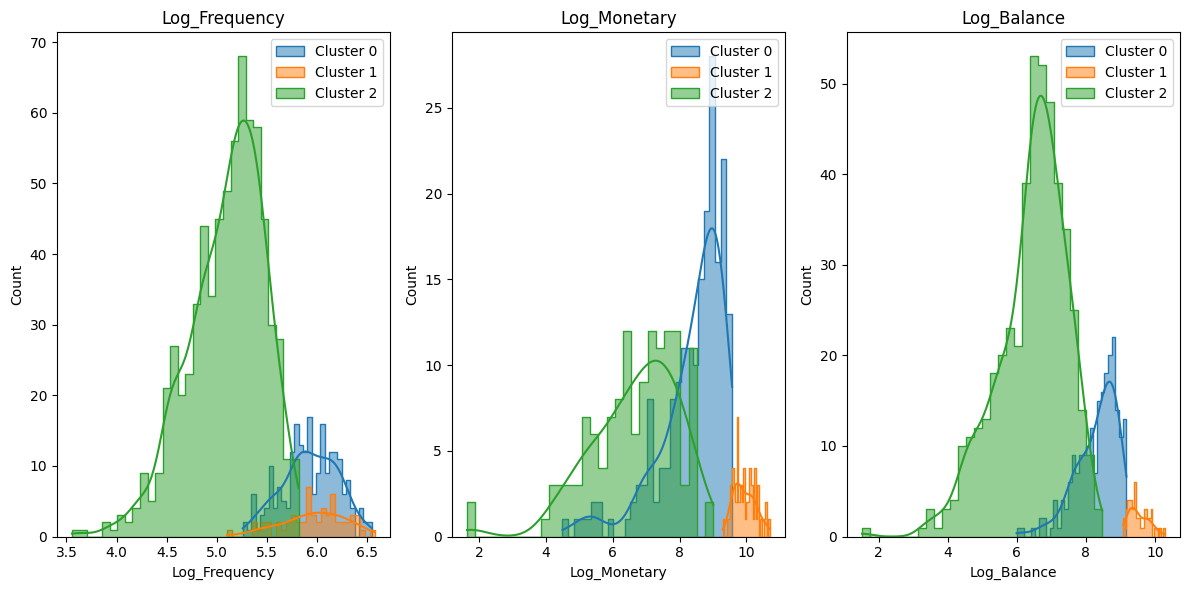

In [38]:
# Apply log transformation to 'Frequency' and 'Monetary' to handle wide ranges
fmb['Log_Frequency'] = np.log1p(fmb['Frequency'])
fmb['Log_Monetary'] = np.log1p(fmb['MonetaryValue'])
fmb['Log_Balance'] = np.log1p(fmb['Balance'])

fig, axes = plt.subplots(1, 3, figsize=(12, 6))  # Increased figure size
axes = axes.flatten()

fmb_features = [ 'Log_Frequency', 'Log_Monetary','Log_Balance']
for i, feature in enumerate(fmb_features):
    for cluster in range(kmeans.n_clusters):
        # Adjust bin size for better visualization
        sns.histplot(fmb[fmb['Cluster'] == cluster][feature], ax=axes[i], label=f'Cluster {cluster}', kde=True, bins=30, element='step')
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

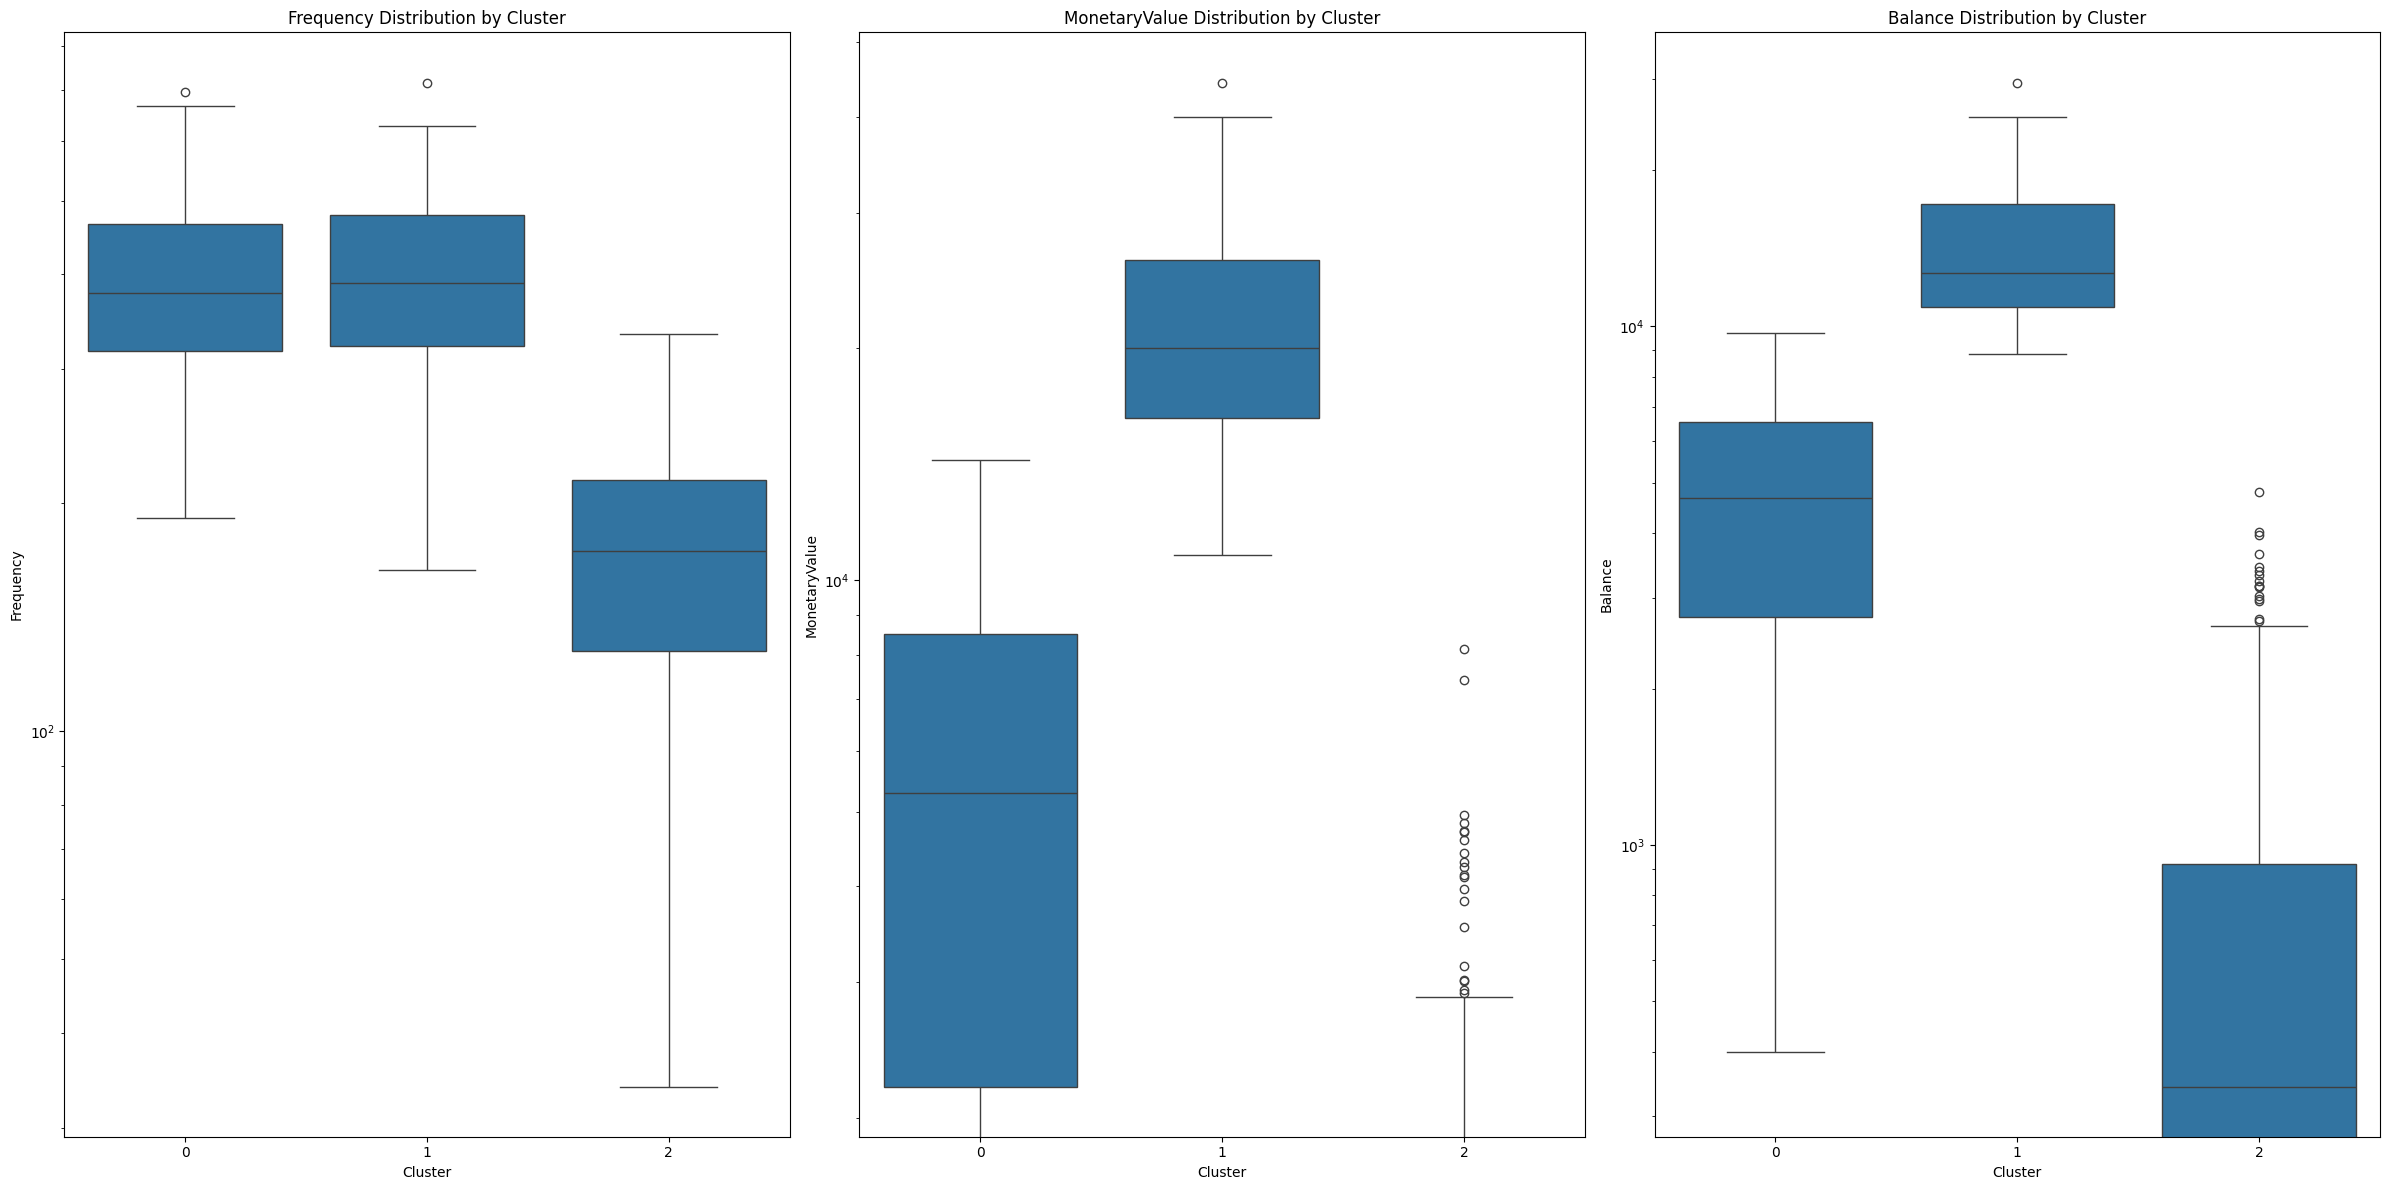

In [39]:
features = ['Frequency', 'MonetaryValue', 'Balance']
fig, axes = plt.subplots(1, 3, figsize=(24, 12))  # Adjust the size as needed

for i, feature in enumerate(features):
    sns.boxplot(x='Cluster', y=feature, data=fmb, ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Cluster')
    # Optional: To improve readability, you might log-transform Frequency and Monetary values
    if feature in ['Frequency', 'MonetaryValue','Balance']:
        axes[i].set_yscale('log')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()